# Machine-learning classifiers for predicting sample characteristics

In this notebook we tried to train a classifier to predict alcohol consumption. First, the relevant data was loaded. Since the data for all classes is very unbalanced, we first had to use a method called undersmapling. This involved adjusting the size of the larger class to the size of the smaller class in order to create an unbiased classifier. Then, different classifiers were trained with different hyperparameters. Due to the strong class imbalance in the variables, the undersampling resulted in a reduction of the samples, which compromised the training process. Finally, a random forest model was trained as it gave the best results. However, the accuracy did not exceed 77%. Lastly, the classifier was visualised.

In [1]:
import os
import pandas as pd
import numpy as np
import qiime2 as q2
from qiime2 import Visualization
from scipy.stats import shapiro, kruskal, f_oneway
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
data_dir = 'project_data'


if not os.path.isdir(data_dir):
    os.makedirs(data_dir) 

# 1. Data import

In [3]:
#filtered sequence
! wget -nv -O $data_dir/rep-seqs.qza 'https://polybox.ethz.ch/index.php/s/MBLSUQXzglnn66u/download?path=%2F&files=Sequences_rep_set.qza'

# Feature Table
! wget -nv -O $data_dir/table.qza 'https://polybox.ethz.ch/index.php/s/MBLSUQXzglnn66u/download?path=%2F&files=Feature_table.qza'

# Taxonomy file generate from silva
! wget -nv -O $data_dir/taxonomy_1.qza 'https://polybox.ethz.ch/index.php/s/MBLSUQXzglnn66u/download?path=%2F&files=taxonomy_1.qza'

# Phylogeny file 
! wget -nv -O $data_dir/fasttree-tree-rooted.qza 'https://polybox.ethz.ch/index.php/s/MBLSUQXzglnn66u/download?path=%2F&files=fasttree-tree-rooted.qza'

# Metadata
! wget -nv -O $data_dir/sample_metadata.tsv 'https://polybox.ethz.ch/index.php/s/MBLSUQXzglnn66u/download?path=%2F&files=metadata-nutrition.tsv'

2022-12-17 08:39:29 URL:https://polybox.ethz.ch/index.php/s/MBLSUQXzglnn66u/download?path=%2F&files=Sequences_rep_set.qza [390624/390624] -> "project_data/rep-seqs.qza" [1]
2022-12-17 08:39:30 URL:https://polybox.ethz.ch/index.php/s/MBLSUQXzglnn66u/download?path=%2F&files=Feature_table.qza [504534/504534] -> "project_data/table.qza" [1]
2022-12-17 08:39:30 URL:https://polybox.ethz.ch/index.php/s/MBLSUQXzglnn66u/download?path=%2F&files=taxonomy_1.qza [303165/303165] -> "project_data/taxonomy_1.qza" [1]
2022-12-17 08:39:31 URL:https://polybox.ethz.ch/index.php/s/MBLSUQXzglnn66u/download?path=%2F&files=fasttree-tree-rooted.qza [249852/249852] -> "project_data/fasttree-tree-rooted.qza" [1]
2022-12-17 08:39:31 URL:https://polybox.ethz.ch/index.php/s/MBLSUQXzglnn66u/download?path=%2F&files=metadata-nutrition.tsv [300302/300302] -> "project_data/sample_metadata.tsv" [1]


### 1.1 Metadata

In [4]:
metadata_df = pd.read_csv(f'project_data/sample_metadata.tsv', sep='\t', float_precision='round_trip')
metadata_df.head()

,sampleid,GEN_age_cat,GEN_age_corrected,GEN_bmi_cat,GEN_bmi_corrected,GEN_cat,GEN_collection_timestamp,GEN_country,GEN_dog,GEN_elevation,...,NUT_probiotic_frequency,NUT_red_meat_frequency,NUT_salted_snacks_frequency,NUT_seafood_frequency,NUT_sugary_sweets_frequency,NUT_vegetable_frequency,NUT_vitamin_b_supplement_frequency,NUT_vitamin_d_supplement_frequency,NUT_whole_eggs,NUT_whole_grain_frequency
0,10317.000046,20s,20.0,Normal,23.75,False,2016-08-25 18:30:00,USA,True,1919.3,...,Rarely,Regularly,Occasionally,Rarely,Occasionally,Occasionally,Never,Never,Daily,Daily
1,10317.000050,Not provided,NaN,Overweight,25.61,False,2016-07-06 09:00:00,United Kingdom,False,65.5,...,Rarely,Rarely,Regularly,Occasionally,Regularly,Regularly,Never,Never,Rarely,Occasionally
2,10317.000038,30s,39.0,Overweight,27.67,False,2016-06-29 09:30:00,United Kingdom,False,44.5,...,Never,Occasionally,Daily,Occasionally,Rarely,Occasionally,Never,Never,Regularly,Occasionally
3,10317.000047,50s,56.0,Normal,19.71,False,2016-07-12 17:30:00,Germany,False,8.7,...,Daily,Occasionally,Rarely,Not provided,Rarely,Regularly,Daily,Daily,Rarely,Regularly
4,10317.000046,40s,45.0,Normal,23.15,False,2016-05-24 19:00:00,United Kingdom,True,68.8,...,Regularly,Never,Never,Occasionally,Never,Daily,Rarely,Occasionally,Regularly,Daily


In [5]:
metadata_df.columns.to_list()

['sampleid',
 'GEN_age_cat',
 'GEN_age_corrected',
 'GEN_bmi_cat',
 'GEN_bmi_corrected',
 'GEN_cat',
 'GEN_collection_timestamp',
 'GEN_country',
 'GEN_dog',
 'GEN_elevation',
 'GEN_geo_loc_name',
 'GEN_height_cm',
 'GEN_host_common_name',
 'GEN_last_move',
 'GEN_last_travel',
 'GEN_latitude',
 'GEN_level_of_education',
 'GEN_longitude',
 'GEN_race',
 'GEN_sample_type',
 'GEN_sex',
 'GEN_weight_kg',
 'NUT_alcohol_consumption',
 'NUT_alcohol_frequency',
 'NUT_alcohol_types_beercider',
 'NUT_alcohol_types_red_wine',
 'NUT_alcohol_types_sour_beers',
 'NUT_alcohol_types_spiritshard_alcohol',
 'NUT_alcohol_types_unspecified',
 'NUT_alcohol_types_white_wine',
 'NUT_artificial_sweeteners',
 'NUT_diet_type',
 'NUT_drinks_per_session',
 'NUT_fed_as_infant',
 'NUT_fermented_plant_frequency',
 'NUT_frozen_dessert_frequency',
 'NUT_fruit_frequency',
 'NUT_gluten',
 'NUT_high_fat_red_meat_frequency',
 'NUT_homecooked_meals_frequency',
 'NUT_lowgrain_diet_type',
 'NUT_meat_eggs_frequency',
 'NUT_mil

# creating feature table to train with feature and metadata

In [75]:
! qiime sample-classifier metatable --help

Usage: qiime sample-classifier metatable [OPTIONS]

  Convert numeric sample metadata from TSV file into a feature table.
  Optionally merge with an existing feature table. Only numeric metadata
  will be converted; categorical columns will be silently dropped. By
  default, if a table is used as input only samples found in both the table
  and metadata (intersection) are merged, and others are silently dropped.
  Set missing_samples="error" to raise an error if samples found in the
  table are missing from the metadata file. The metadata file can always
  contain a superset of samples. Note that columns will be dropped if they
  are non-numeric, contain no unique values (zero variance), contain only
  empty cells, or contain negative values. This method currently only
  converts postive numeric metadata into feature data. Tip: convert
  categorical columns to dummy variables to include them in the output
  feature table.

Inputs:
  --i-table ARTIFACT FeatureTable[Frequency]
          

In [6]:
! qiime sample-classifier metatable \
  --i-table $data_dir/table.qza \
  --m-metadata-file $data_dir/sample_metadata.tsv \
  --p-missing-values 'drop_samples' \
  --o-converted-table $data_dir/table-w-metadata.qza

Saved FeatureTable[Frequency] to: project_data/table-w-metadata.qza


In [7]:
! qiime feature-table summarize \
    --i-table $data_dir/table-w-metadata.qza \
    --m-sample-metadata-file $data_dir/sample_metadata.tsv \
    --o-visualization $data_dir/table-w-metadata.qzv

Saved Visualization to: project_data/table-w-metadata.qzv


In [3]:
Visualization.load(f'{data_dir}/table-w-metadata.qzv')

<visualization: Visualization uuid: 92621885-5183-44cf-8db4-8f85c0f7b8df>

## correct imbalance data -- undersampling

In [86]:
meta_df = pd.read_csv(f'project_data/sample_metadata.tsv', sep='\t')
shuffled_df = meta_df.sample(frac=1,random_state=14)

# Find the amount of non-alcohol drinkers
alc_df = shuffled_df.loc[shuffled_df['NUT_alcohol_consumption'] == False]
alc_df.shape

(108, 57)

In [87]:
#Randomly select 108 observations from the alcohol consuming class (majority class)
non_alc_df = shuffled_df.loc[shuffled_df['NUT_alcohol_consumption'] == True].sample(n=108,random_state=14)

# Concatenate both dataframes again and save them in a tsv file
normalized_df = pd.concat([alc_df, non_alc_df])
normalized_df.head()
normalized_df.to_csv(f'project_data/sample_metadata_balaced.tsv', sep='\t',index=False)

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


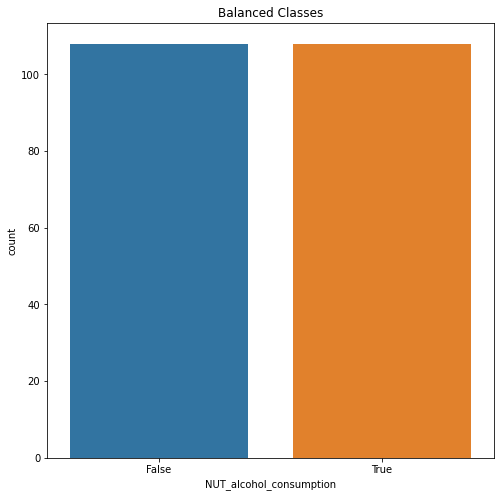

In [88]:
#plot the dataset after the undersampling
plt.figure(figsize=(8, 8))
sns.countplot('NUT_alcohol_consumption', data=normalized_df)
plt.title('Balanced Classes')
plt.show()

# 2. Random Forest classifier

might not be siutable as we have a small dataset!

Tested 25 differrent settings. Achieved overall accuracy of 0.777778 with random forest estimator. RF-ALC-cons-balanced5/accuracy_results.qzv 300 esitmators and 0.1 split. With the following settings:

In [9]:
! qiime sample-classifier classify-samples

Usage: qiime sample-classifier classify-samples [OPTIONS]

  Predicts a categorical sample metadata column using a supervised learning
  classifier. Splits input data into training and test sets. The training
  set is used to train and test the estimator using a stratified k-fold
  cross-validation scheme. This includes optional steps for automated
  feature extraction and hyperparameter optimization. The test set validates
  classification accuracy of the optimized estimator. Outputs classification
  results for test set. For more details on the learning algorithm, see
  http://scikit-learn.org/stable/supervised_learning.html

Inputs:
  --i-table ARTIFACT FeatureTable[Frequency]
                       Feature table containing all features that should be
                       used for target prediction.                  [required]
Parameters:
  --m-metadata-file METADATA
  --m-metadata-column COLUMN  MetadataColumn[Categorical]
                       Categorical metadata column to use

In [8]:
! qiime sample-classifier classify-samples \
    --i-table $data_dir/table-w-metadata.qza \
    --m-metadata-file $data_dir/sample_metadata_balaced.tsv \
    --m-metadata-column 'NUT_alcohol_consumption' \
    --p-test-size 0.1 \
    --p-step 0.05 \
    --p-estimator RandomForestClassifier \
    --p-random-state 14 \
    --p-n-estimators 300 \
    --p-optimize-feature-selection True \
    --p-parameter-tuning True \
    --p-missing-samples 'ignore' \
    --p-cv 15 \
    --output-dir $data_dir/RF-ALC-cons-balanced26

Saved SampleEstimator[Classifier] to: project_data/RF-ALC-cons-balanced26/sample_estimator.qza
Saved FeatureData[Importance] to: project_data/RF-ALC-cons-balanced26/feature_importance.qza
Saved SampleData[ClassifierPredictions] to: project_data/RF-ALC-cons-balanced26/predictions.qza
Saved Visualization to: project_data/RF-ALC-cons-balanced26/model_summary.qzv
Saved Visualization to: project_data/RF-ALC-cons-balanced26/accuracy_results.qzv
Saved SampleData[Probabilities] to: project_data/RF-ALC-cons-balanced26/probabilities.qza
Saved Visualization to: project_data/RF-ALC-cons-balanced26/heatmap.qzv
Saved SampleData[TrueTargets] to: project_data/RF-ALC-cons-balanced26/training_targets.qza
Saved SampleData[TrueTargets] to: project_data/RF-ALC-cons-balanced26/test_targets.qza


In [9]:
Visualization.load(f'{data_dir}/RF-ALC-cons-balanced5/accuracy_results.qzv')

<visualization: Visualization uuid: 96c9afc5-4eab-4831-8d16-e1a845a60412>

In [7]:
Visualization.load(f'{data_dir}/RF-ALC-cons-balanced5/model_summary.qzv')

<visualization: Visualization uuid: 21d63401-b2d4-4f5b-aa87-270c9083aebc>

### Other trials with Random Forest

In [74]:
! qiime metadata tabulate \
  --m-input-file $data_dir/RF-ALC-cons-balanced5/test_targets.qza \
  --m-input-file $data_dir/RF-ALC-cons-balanced5/predictions.qza \
  --m-input-file $data_dir/RF-ALC-cons-balanced5/probabilities.qza \
  --o-visualization $data_dir/RF-ALC-cons-balanced5/test_predprob.qzv

Saved Visualization to: project_data/RF-ALC-cons-balanced5/test_predprob.qzv


In [75]:
Visualization.load(f'{data_dir}/RF-ALC-cons-balanced5/test_predprob.qzv')

<visualization: Visualization uuid: 0f62e5d8-b1f0-4895-a137-6b21474e5d63>

In [76]:
! qiime metadata tabulate \
    --m-input-file $data_dir/RF-ALC-cons-balanced5/feature_importance.qza \
    --o-visualization $data_dir/RF-ALC-cons-balanced5/feature_importance.qzv

Saved Visualization to: project_data/RF-ALC-cons-balanced5/feature_importance.qzv


In [77]:
Visualization.load(f'{data_dir}/RF-ALC-cons-balanced5/feature_importance.qzv')

<visualization: Visualization uuid: 46c999e3-eb81-4624-8219-4e4ea27075f7>

In [78]:
! qiime sample-classifier heatmap \
  --i-table $data_dir/table-w-metadata.qza \
  --i-importance $data_dir/RF-ALC-cons-balanced5/feature_importance.qza \
  --m-sample-metadata-file $data_dir/sample_metadata_balaced.tsv  \
  --m-sample-metadata-column 'NUT_alcohol_consumption' \
  --p-group-samples \
  --p-feature-count 30 \
  --o-filtered-table $data_dir/RF-ALC-cons-balanced5/important-feature-table-top-30.qza \
  --o-heatmap $data_dir/RF-ALC-cons-balanced5/important-feature-heatmap.qzv

Saved Visualization to: project_data//RF-ALC-cons-balanced5/important-feature-heatmap.qzv
Saved FeatureTable[Frequency] to: project_data//RF-ALC-cons-balanced5/important-feature-table-top-30.qza


In [79]:
Visualization.load(f'{data_dir}/RF-ALC-cons-balanced5/important-feature-heatmap.qzv')

<visualization: Visualization uuid: 5c044dfc-3da6-4a8d-86f7-45470c0d1437>

In [81]:
! qiime sample-classifier classify-samples \
    --i-table $data_dir/table-w-metadata.qza \
    --m-metadata-file $data_dir/sample_metadata.tsv \
    --m-metadata-column 'NUT_alcohol_frequency' \
    --p-test-size 0.2 \
    --p-estimator RandomForestClassifier \
    --p-random-state 14 \
    --p-n-estimators 200 \
    --p-optimize-feature-selection True \
    --p-parameter-tuning True \
    --p-missing-samples 'ignore' \
    --p-cv 10 \
    --output-dir $data_dir/RF-ALC-freq-4

Saved SampleEstimator[Classifier] to: project_data/RF-ALC-freq-4/sample_estimator.qza
Saved FeatureData[Importance] to: project_data/RF-ALC-freq-4/feature_importance.qza
Saved SampleData[ClassifierPredictions] to: project_data/RF-ALC-freq-4/predictions.qza
Saved Visualization to: project_data/RF-ALC-freq-4/model_summary.qzv
Saved Visualization to: project_data/RF-ALC-freq-4/accuracy_results.qzv
Saved SampleData[Probabilities] to: project_data/RF-ALC-freq-4/probabilities.qza
Saved Visualization to: project_data/RF-ALC-freq-4/heatmap.qzv
Saved SampleData[TrueTargets] to: project_data/RF-ALC-freq-4/training_targets.qza
Saved SampleData[TrueTargets] to: project_data/RF-ALC-freq-4/test_targets.qza


In [82]:
Visualization.load(f'{data_dir}/RF-ALC-freq-4/accuracy_results.qzv')

<visualization: Visualization uuid: 8c42bde9-b595-4bcf-aa7f-da364424b37d>

In [83]:
! qiime sample-classifier classify-samples \
    --i-table $data_dir/table-w-metadata.qza \
    --m-metadata-file $data_dir/sample_metadata.tsv \
    --m-metadata-column 'NUT_alcohol_consumption' \
    --p-test-size 0.2 \
    --p-estimator RandomForestClassifier \
    --p-random-state 14 \
    --p-n-estimators 200 \
    --p-optimize-feature-selection True \
    --p-parameter-tuning True \
    --p-missing-samples 'ignore' \
    --p-cv 5 \
    --output-dir $data_dir/RF-ALC-cons-2

Saved SampleEstimator[Classifier] to: project_data/RF-ALC-cons-2/sample_estimator.qza
Saved FeatureData[Importance] to: project_data/RF-ALC-cons-2/feature_importance.qza
Saved SampleData[ClassifierPredictions] to: project_data/RF-ALC-cons-2/predictions.qza
Saved Visualization to: project_data/RF-ALC-cons-2/model_summary.qzv
Saved Visualization to: project_data/RF-ALC-cons-2/accuracy_results.qzv
Saved SampleData[Probabilities] to: project_data/RF-ALC-cons-2/probabilities.qza
Saved Visualization to: project_data/RF-ALC-cons-2/heatmap.qzv
Saved SampleData[TrueTargets] to: project_data/RF-ALC-cons-2/training_targets.qza
Saved SampleData[TrueTargets] to: project_data/RF-ALC-cons-2/test_targets.qza


In [84]:
Visualization.load(f'{data_dir}/RF-ALC-cons-2/accuracy_results.qzv')

<visualization: Visualization uuid: 3fb23c7d-206b-49df-b1bd-77b1dcc63cbe>

In [13]:
! qiime sample-classifier classify-samples \
  --i-table $data_dir/table.qza \
  --m-metadata-file $data_dir/sample_metadata.tsv \
  --m-metadata-column 'NUT_alcohol_consumption' \
  --p-random-state 666 \
  --p-n-jobs 1 \
  --output-dir $data_dir/Alcohol-classifier-results/

Saved SampleEstimator[Classifier] to: project_data/Alcohol-classifier-results/sample_estimator.qza
Saved FeatureData[Importance] to: project_data/Alcohol-classifier-results/feature_importance.qza
Saved SampleData[ClassifierPredictions] to: project_data/Alcohol-classifier-results/predictions.qza
Saved Visualization to: project_data/Alcohol-classifier-results/model_summary.qzv
Saved Visualization to: project_data/Alcohol-classifier-results/accuracy_results.qzv
Saved SampleData[Probabilities] to: project_data/Alcohol-classifier-results/probabilities.qza
Saved Visualization to: project_data/Alcohol-classifier-results/heatmap.qzv
Saved SampleData[TrueTargets] to: project_data/Alcohol-classifier-results/training_targets.qza
Saved SampleData[TrueTargets] to: project_data/Alcohol-classifier-results/test_targets.qza


In [14]:
Visualization.load(f'{data_dir}/Alcohol-classifier-results/heatmap.qzv')

<visualization: Visualization uuid: d3464519-749f-4059-bae1-e57255341cc9>

In [15]:
Visualization.load(f'{data_dir}/Alcohol-classifier-results/accuracy_results.qzv')

<visualization: Visualization uuid: 5d4b2946-7c95-487e-adbc-0bdd1d8064b4>

# 3. Linear SVC

Sklearn suggest linear SVC for small dataset. Did not exceed Baseline Accuracy.

In [44]:
! qiime sample-classifier classify-samples \
    --i-table $data_dir/table-w-metadata.qza \
    --m-metadata-file $data_dir/sample_metadata_balaced.tsv \
    --m-metadata-column 'NUT_alcohol_consumption' \
    --p-test-size 0.2 \
    --p-estimator LinearSVC \
    --p-random-state 14 \
    --p-n-estimators 100 \
    --p-optimize-feature-selection False \
    --p-parameter-tuning False \
    --p-cv 10 \
    --p-missing-samples 'ignore' \
    --output-dir $data_dir/LinearSVC-Alc-C-balanced2

Saved SampleEstimator[Classifier] to: project_data/LinearSVC-Alc-C-balanced2/sample_estimator.qza
Saved FeatureData[Importance] to: project_data/LinearSVC-Alc-C-balanced2/feature_importance.qza
Saved SampleData[ClassifierPredictions] to: project_data/LinearSVC-Alc-C-balanced2/predictions.qza
Saved Visualization to: project_data/LinearSVC-Alc-C-balanced2/model_summary.qzv
Saved Visualization to: project_data/LinearSVC-Alc-C-balanced2/accuracy_results.qzv
Saved SampleData[Probabilities] to: project_data/LinearSVC-Alc-C-balanced2/probabilities.qza
Saved Visualization to: project_data/LinearSVC-Alc-C-balanced2/heatmap.qzv
Saved SampleData[TrueTargets] to: project_data/LinearSVC-Alc-C-balanced2/training_targets.qza
Saved SampleData[TrueTargets] to: project_data/LinearSVC-Alc-C-balanced2/test_targets.qza


In [3]:
Visualization.load(f'{data_dir}/LinearSVC-Alc-C-balanced2/accuracy_results.qzv')

<visualization: Visualization uuid: 80b544b6-ac13-4d40-9fed-55e81525db14>

# 3. KNeighborsClassifier Classifier

is suggested if Linear SVC does not work. Did not exceed Baseline Accuracy.

In [54]:
! qiime sample-classifier classify-samples \
    --i-table $data_dir/table-w-metadata.qza \
    --m-metadata-file $data_dir/sample_metadata_balaced.tsv \
    --m-metadata-column 'NUT_alcohol_consumption' \
    --p-test-size 0.2 \
    --p-estimator KNeighborsClassifier \
    --p-random-state 14 \
    --p-optimize-feature-selection True \
    --p-parameter-tuning True \
    --p-cv 15 \
    --p-missing-samples 'ignore' \
    --output-dir $data_dir/KNeighborsClassifier-Alc-cons-balanced4

Saved SampleEstimator[Classifier] to: project_data/KNeighborsClassifier-Alc-cons-balanced4/sample_estimator.qza
Saved FeatureData[Importance] to: project_data/KNeighborsClassifier-Alc-cons-balanced4/feature_importance.qza
Saved SampleData[ClassifierPredictions] to: project_data/KNeighborsClassifier-Alc-cons-balanced4/predictions.qza
Saved Visualization to: project_data/KNeighborsClassifier-Alc-cons-balanced4/model_summary.qzv
Saved Visualization to: project_data/KNeighborsClassifier-Alc-cons-balanced4/accuracy_results.qzv
Saved SampleData[Probabilities] to: project_data/KNeighborsClassifier-Alc-cons-balanced4/probabilities.qza
Saved Visualization to: project_data/KNeighborsClassifier-Alc-cons-balanced4/heatmap.qzv
Saved SampleData[TrueTargets] to: project_data/KNeighborsClassifier-Alc-cons-balanced4/training_targets.qza
Saved SampleData[TrueTargets] to: project_data/KNeighborsClassifier-Alc-cons-balanced4/test_targets.qza


In [4]:
Visualization.load(f'{data_dir}/KNeighborsClassifier-Alc-cons-balanced4/accuracy_results.qzv')

<visualization: Visualization uuid: 13dbfa61-ffcd-4608-8262-2dd0399d8828>

# Visualization

In [70]:
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.pipeline import Pipeline


In [71]:
normalized_df = pd.read_csv(f'project_data/sample_metadata_balaced.tsv', sep='\t')

In [72]:
features = q2.Artifact.load(f'project_data/table-w-metadata.qza')
feature_df = features.view(q2.Metadata).to_dataframe()
X=feature_df.columns.to_list()

In [73]:
classifier_artifact = q2.Artifact.load('project_data/RF-ALC-cons-balanced5/sample_estimator.qza')
pipeline = classifier_artifact.view(Pipeline)
loaded_model = pipeline['est']

In [74]:
loaded_model[1]

DecisionTreeClassifier(max_depth=16, max_features=0.1, min_samples_split=0.01,
                       min_weight_fraction_leaf=0.001, random_state=1812018520)

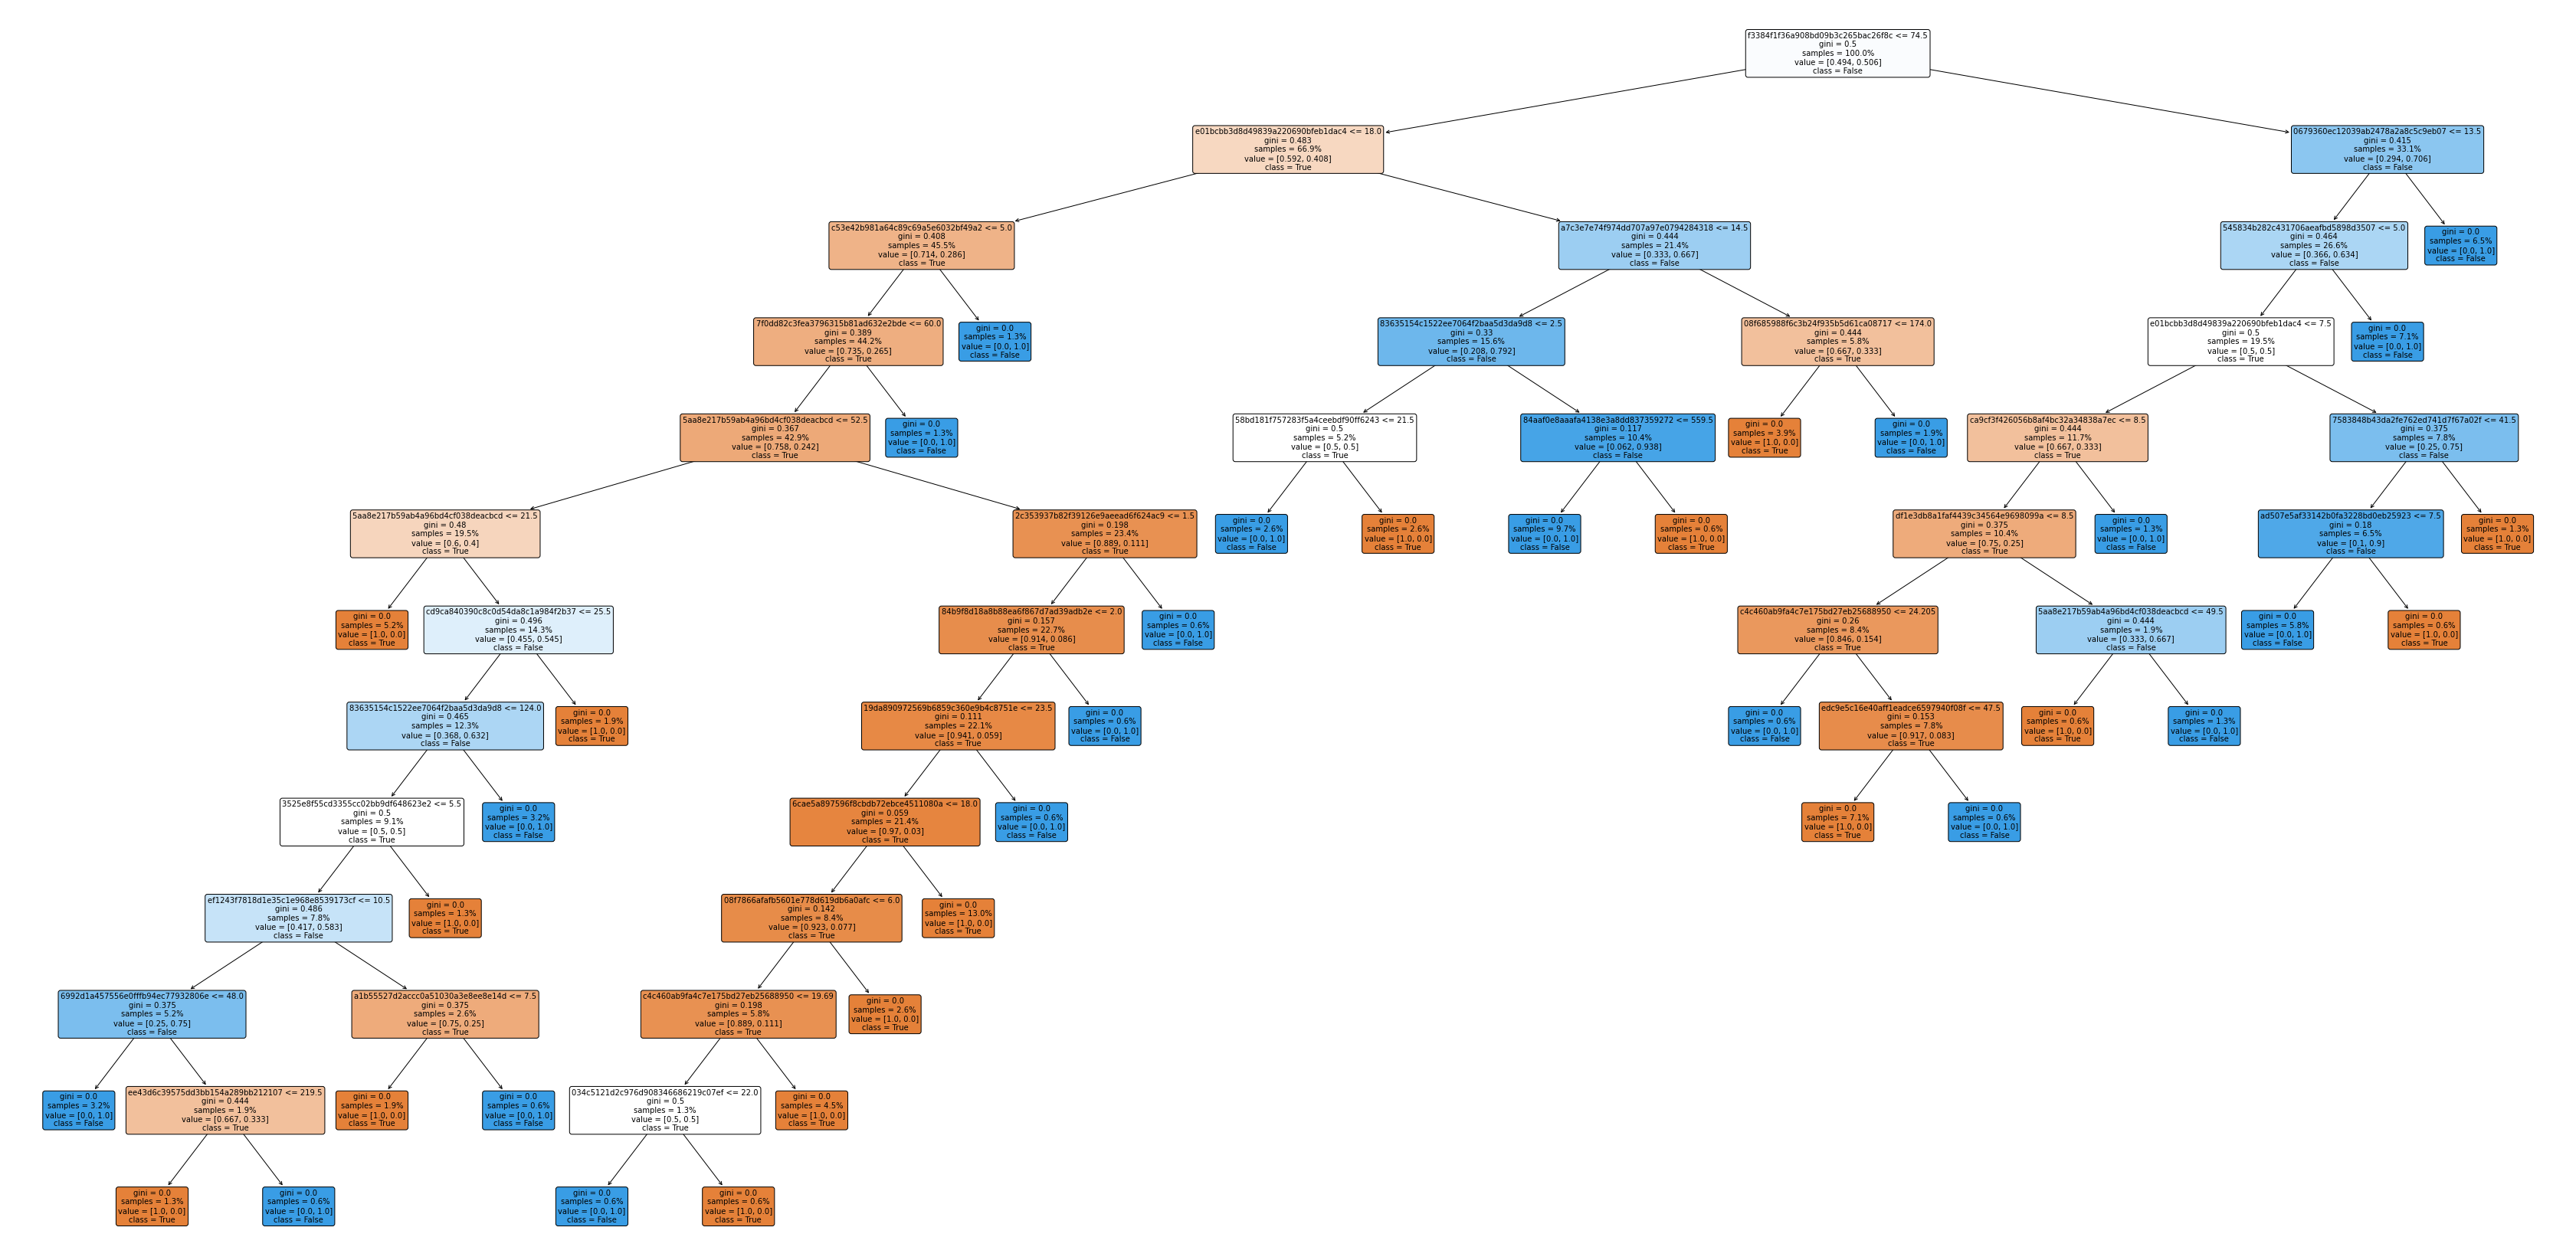

In [80]:
x_label=['True', 'False']
plt.figure(figsize=(60,30))
tree.plot_tree(loaded_model[10], 
          feature_names=X,
          class_names=x_label, 
          filled=True, 
          rounded=True,
          proportion=True,
          fontsize=10)

plt.savefig('figures/Example_tree.png', bbox_inches="tight")